<a href="https://colab.research.google.com/github/Fahad16301139/Ponzi-scheme-detection-Ethereum-/blob/main/ponzi_detectiom_scheme_XGboost%2BGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

# Load the data
data = pd.read_csv('Ponzi_contracts.csv')

# Add new columns 'opcode_length', 'opcode_count', and 'unique_opcode_count'
data['opcode_length'] = data['opcode'].apply(len)
data['opcode_count'] = data['opcode'].apply(lambda x: len(x.split()))
data['unique_opcode_count'] = data['opcode'].apply(lambda x: len(set(x.split())))

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert 'address' to integer
train_data['address'] = train_data['address'].apply(lambda x: int(x, 16))
test_data['address'] = test_data['address'].apply(lambda x: int(x, 16))

# Create a scaler object for 'address'
scaler_address = MinMaxScaler()

# Fit the scaler and transform the 'address' column of the training data
train_data['address'] = scaler_address.fit_transform(train_data[['address']])

# Transform the 'address' column of the testing data using the same scaler
test_data['address'] = scaler_address.transform(test_data[['address']])

# Create a scaler object for 'opcode_length'
scaler_opcode_length = MinMaxScaler()

# Fit the scaler and transform the 'opcode_length' column of the training data
train_data['opcode_length'] = scaler_opcode_length.fit_transform(train_data[['opcode_length']])

# Transform the 'opcode_length' column of the testing data using the same scaler
test_data['opcode_length'] = scaler_opcode_length.transform(test_data[['opcode_length']])

# Train an XGBoost Classifier on the numerical features
xgb = XGBClassifier()
xgb.fit(train_data[['address', 'opcode_length', 'opcode_count', 'unique_opcode_count']], train_data['label'])

# Extract the features from the XGBoost Classifier
xgb_features_train = xgb.predict_proba(train_data[['address', 'opcode_length', 'opcode_count', 'unique_opcode_count']])[:, 1].reshape(-1, 1)
xgb_features_test = xgb.predict_proba(test_data[['address', 'opcode_length', 'opcode_count', 'unique_opcode_count']])[:, 1].reshape(-1, 1)

# Encode the opcode sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['opcode'])
sequences_train = tokenizer.texts_to_sequences(train_data['opcode'])
sequences_test = tokenizer.texts_to_sequences(test_data['opcode'])
X_opcode_train = pad_sequences(sequences_train, maxlen=200)
X_opcode_test = pad_sequences(sequences_test, maxlen=200)

# Train a GRU on the opcode sequences
gru = Sequential()
gru.add(Embedding(5000, 128, input_length=200))
gru.add(GRU(128))
gru.add(Dense(64, activation='relu'))  # New dense layer
gru.add(Dense(1, activation='sigmoid'))  # Final dense layer with sigmoid activation for binary classification
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru.fit(X_opcode_train, train_data['label'], epochs=10, validation_split=0.2)

# Extract the features from the GRU
gru_features_train = gru.predict(X_opcode_train)
gru_features_test = gru.predict(X_opcode_test)

# Concatenate the features from the XGBoost Classifier and GRU
features_train = np.concatenate([xgb_features_train, gru_features_train], axis=1)
features_test = np.concatenate([xgb_features_test, gru_features_test], axis=1)

# Train a final XGBoost model on the concatenated features
final_xgb = XGBClassifier()
final_xgb.fit(features_train, train_data['label'])

# Evaluate the final XGBoost model
final_xgb.score(features_test, test_data['label'])
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the labels for the test set
y_pred = final_xgb.predict(features_test)

# Calculate metrics
accuracy = accuracy_score(test_data['label'], y_pred)
precision = precision_score(test_data['label'], y_pred)
recall = recall_score(test_data['label'], y_pred)
f1 = f1_score(test_data['label'], y_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print the confusion matrix
print(confusion_matrix(test_data['label'], y_pred))



Epoch 1/10
76/76 [==============================] - 29s 333ms/step - loss: 0.2449 - accuracy: 0.9443 - val_loss: 0.1518 - val_accuracy: 0.9620
Epoch 2/10
76/76 [==============================] - 23s 304ms/step - loss: 0.1517 - accuracy: 0.9620 - val_loss: 0.1378 - val_accuracy: 0.9637
Epoch 3/10
76/76 [==============================] - 29s 382ms/step - loss: 0.1442 - accuracy: 0.9628 - val_loss: 0.1342 - val_accuracy: 0.9653
Epoch 4/10
76/76 [==============================] - 24s 316ms/step - loss: 0.1303 - accuracy: 0.9633 - val_loss: 0.1261 - val_accuracy: 0.9653
Epoch 5/10
76/76 [==============================] - 24s 321ms/step - loss: 0.1128 - accuracy: 0.9645 - val_loss: 0.1171 - val_accuracy: 0.9653
Epoch 6/10
76/76 [==============================] - 25s 323ms/step - loss: 0.1073 - accuracy: 0.9645 - val_loss: 0.1324 - val_accuracy: 0.9670
Epoch 7/10
76/76 [==============================] - 24s 318ms/step - loss: 0.1020 - accuracy: 0.9678 - val_loss: 0.1454 - val_accuracy: 0.9554

Epoch 1/10
76/76 [==============================] - 28s 331ms/step - loss: 0.2448 - accuracy: 0.9455 - val_loss: 0.1418 - val_accuracy: 0.9637
Epoch 2/10
76/76 [==============================] - 25s 335ms/step - loss: 0.1529 - accuracy: 0.9620 - val_loss: 0.1392 - val_accuracy: 0.9637
Epoch 3/10
76/76 [==============================] - 25s 324ms/step - loss: 0.1416 - accuracy: 0.9624 - val_loss: 0.1394 - val_accuracy: 0.9653
Epoch 4/10
76/76 [==============================] - 24s 323ms/step - loss: 0.1276 - accuracy: 0.9633 - val_loss: 0.1359 - val_accuracy: 0.9653
Epoch 5/10
76/76 [==============================] - 24s 323ms/step - loss: 0.1195 - accuracy: 0.9653 - val_loss: 0.1182 - val_accuracy: 0.9703
Epoch 6/10
76/76 [==============================] - 25s 324ms/step - loss: 0.1110 - accuracy: 0.9653 - val_loss: 0.1459 - val_accuracy: 0.9653
Epoch 7/10
76/76 [==============================] - 25s 325ms/step - loss: 0.0966 - accuracy: 0.9682 - val_loss: 0.1182 - val_accuracy: 0.9653

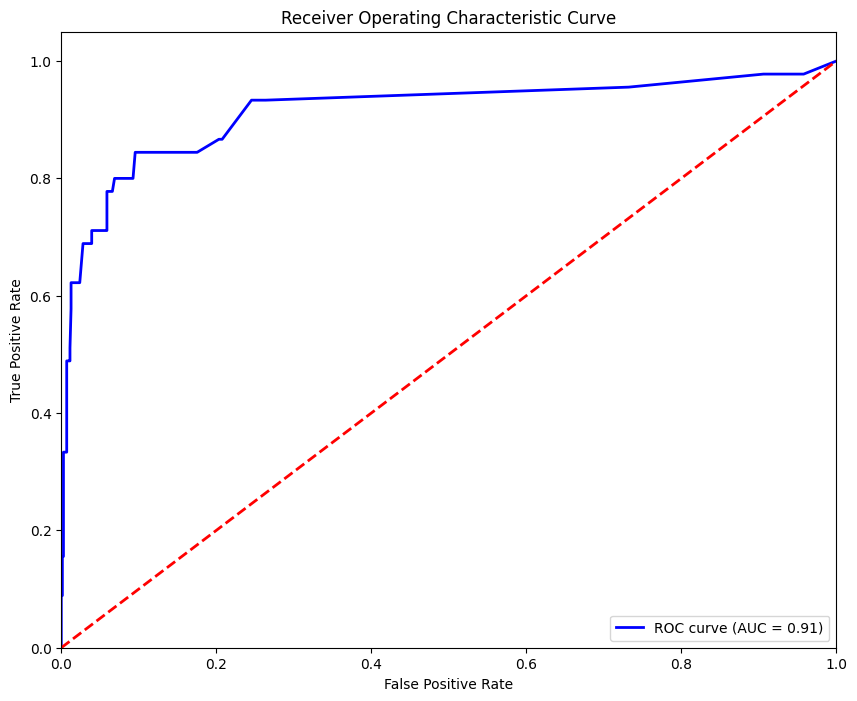

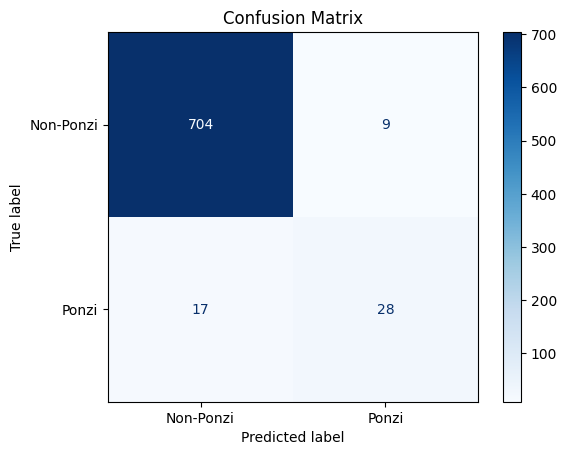

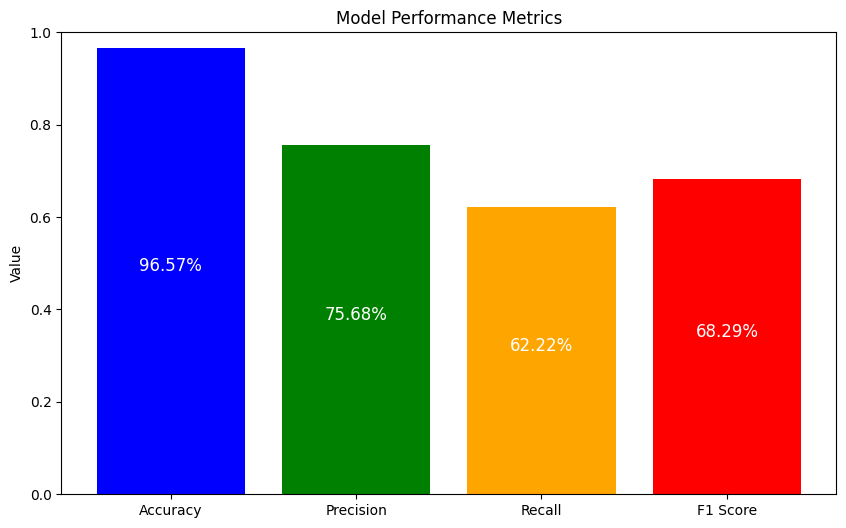

In [ ]:
#MODEL with feature EXTRACTION
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

# Load the data
data = pd.read_csv('Ponzi_contracts.csv')

# Add new columns 'opcode_length', 'opcode_count', and 'unique_opcode_count'
data['opcode_length'] = data['opcode'].apply(len)
data['opcode_count'] = data['opcode'].apply(lambda x: len(x.split()))
data['unique_opcode_count'] = data['opcode'].apply(lambda x: len(set(x.split())))

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create a scaler object for 'opcode_length'
scaler_opcode_length = MinMaxScaler()

# Fit the scaler and transform the 'opcode_length' column of the training data
train_data['opcode_length'] = scaler_opcode_length.fit_transform(train_data[['opcode_length']])

# Transform the 'opcode_length' column of the testing data using the same scaler
test_data['opcode_length'] = scaler_opcode_length.transform(test_data[['opcode_length']])

# Train an XGBoost Classifier on the numerical features (excluding 'address')
xgb = XGBClassifier()
xgb.fit(train_data[['opcode_length', 'opcode_count', 'unique_opcode_count']], train_data['label'])

# Extract the features from the XGBoost Classifier
xgb_features_train = xgb.predict_proba(train_data[['opcode_length', 'opcode_count', 'unique_opcode_count']])[:, 1].reshape(-1, 1)
xgb_features_test = xgb.predict_proba(test_data[['opcode_length', 'opcode_count', 'unique_opcode_count']])[:, 1].reshape(-1, 1)

# Encode the opcode sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['opcode'])
sequences_train = tokenizer.texts_to_sequences(train_data['opcode'])
sequences_test = tokenizer.texts_to_sequences(test_data['opcode'])
X_opcode_train = pad_sequences(sequences_train, maxlen=200)
X_opcode_test = pad_sequences(sequences_test, maxlen=200)

# Train a GRU on the opcode sequences
gru = Sequential()
gru.add(Embedding(5000, 128, input_length=200))
gru.add(GRU(128))
gru.add(Dense(64, activation='relu'))  # New dense layer
gru.add(Dense(1, activation='sigmoid'))  # Final dense layer with sigmoid activation for binary classification
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru.fit(X_opcode_train, train_data['label'], epochs=10, validation_split=0.2)

# Extract the features from the GRU
gru_features_train = gru.predict(X_opcode_train)
gru_features_test = gru.predict(X_opcode_test)

# Concatenate the features from the XGBoost Classifier and GRU
features_train = np.concatenate([xgb_features_train, gru_features_train], axis=1)
features_test = np.concatenate([xgb_features_test, gru_features_test], axis=1)

# Train a final XGBoost model on the concatenated features
final_xgb = XGBClassifier()
final_xgb.fit(features_train, train_data['label'])

# Evaluate the final XGBoost model
final_xgb.score(features_test, test_data['label'])
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict the labels for the test set
y_pred = final_xgb.predict(features_test)

# Calculate metrics
accuracy = accuracy_score(test_data['label'], y_pred)
precision = precision_score(test_data['label'], y_pred)
recall = recall_score(test_data['label'], y_pred)
f1 = f1_score(test_data['label'], y_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print the confusion matrix
print(confusion_matrix(test_data['label'], y_pred))
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_data['label'], final_xgb.predict_proba(features_test)[:, 1])

# Calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
from sklearn.metrics import ConfusionMatrixDisplay

# Get the confusion matrix
cm = confusion_matrix(test_data['label'], y_pred)

# Plot the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Ponzi', 'Ponzi'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

import matplotlib.pyplot as plt

# Values for accuracy, precision, recall, and F1 score
performance_metrics = [accuracy, precision, recall, f1]

# Labels for the metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, performance_metrics, color=['blue', 'green', 'orange', 'red'])

# Adding annotations
for i, value in enumerate(performance_metrics):
    plt.text(i, value/2, f'{value:.2%}', ha='center', color='white', fontsize=12)

plt.ylim(0, 1)
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.show()


Epoch 1/10
76/76 [==============================] - 30s 353ms/step - loss: 0.2216 - accuracy: 0.9562 - val_loss: 0.1398 - val_accuracy: 0.9637
Epoch 2/10
76/76 [==============================] - 26s 345ms/step - loss: 0.1496 - accuracy: 0.9620 - val_loss: 0.1366 - val_accuracy: 0.9637
Epoch 3/10
76/76 [==============================] - 26s 337ms/step - loss: 0.1450 - accuracy: 0.9620 - val_loss: 0.1334 - val_accuracy: 0.9637
Epoch 4/10
76/76 [==============================] - 27s 358ms/step - loss: 0.1371 - accuracy: 0.9624 - val_loss: 0.1364 - val_accuracy: 0.9653
Epoch 5/10
76/76 [==============================] - 28s 369ms/step - loss: 0.1213 - accuracy: 0.9637 - val_loss: 0.1259 - val_accuracy: 0.9686
Epoch 6/10
76/76 [==============================] - 27s 354ms/step - loss: 0.1066 - accuracy: 0.9674 - val_loss: 0.1204 - val_accuracy: 0.9736
Epoch 7/10
76/76 [==============================] - 26s 349ms/step - loss: 0.0953 - accuracy: 0.9707 - val_loss: 0.1501 - val_accuracy: 0.9604

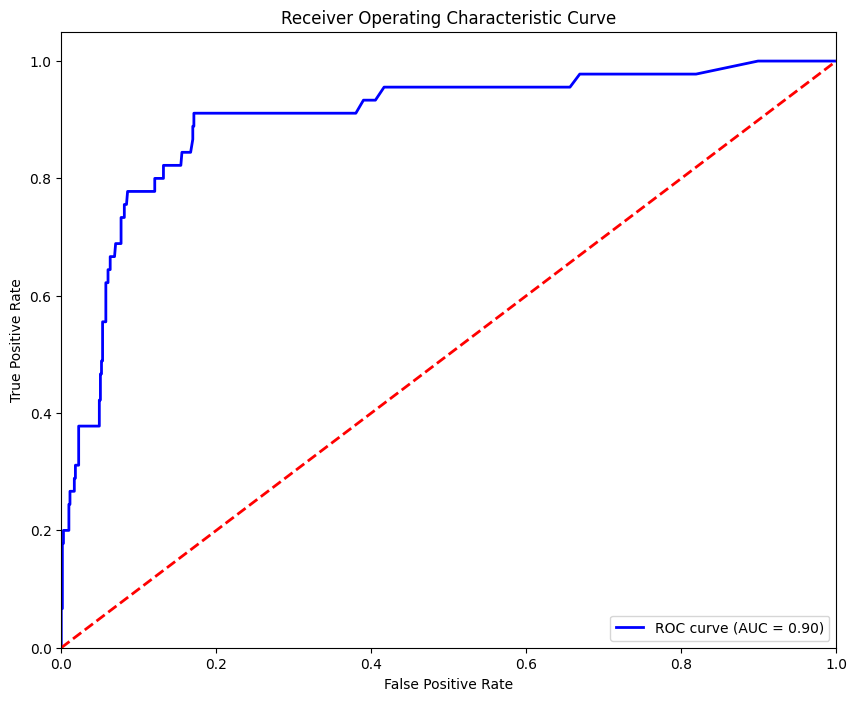

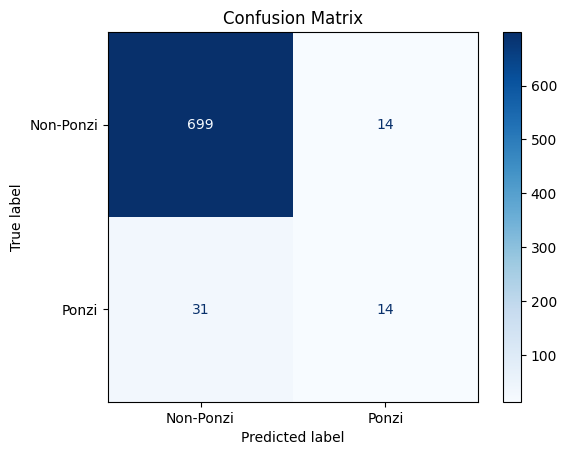

False Positive Rate (FPR): [0.         0.         0.         0.00140252 0.00140252 0.00140252
 0.00280505 0.00280505 0.00981767 0.00981767 0.0112202  0.0112202
 0.01683029 0.01683029 0.01823282 0.01823282 0.02244039 0.02244039
 0.03366059 0.03646564 0.03786816 0.04067321 0.04908836 0.04908836
 0.05049088 0.05049088 0.05189341 0.05189341 0.05329593 0.05329593
 0.05750351 0.05750351 0.06030856 0.06030856 0.0631136  0.0631136
 0.0687237  0.07012623 0.07293128 0.07573633 0.07713885 0.07713885
 0.08134642 0.08134642 0.08415147 0.085554   0.08976157 0.09396914
 0.09537167 0.09957924 0.10378682 0.10799439 0.12061711 0.12061711
 0.12342216 0.12482468 0.12762973 0.13183731 0.13183731 0.14586255
 0.1542777  0.15568022 0.16690042 0.16970547 0.16970547 0.17110799
 0.17110799 0.17391304 0.18232819 0.18373072 0.19354839 0.19775596
 0.20056101 0.20196353 0.20476858 0.20617111 0.21178121 0.21458626
 0.2173913  0.2230014  0.22580645 0.23141655 0.2342216  0.23562412
 0.23842917 0.2398317  0.24263675 0.2

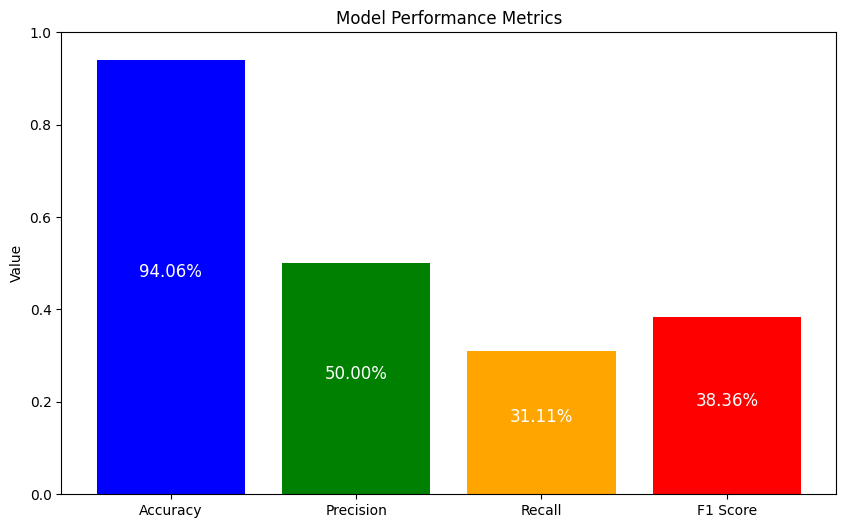

In [ ]:
#model with no feature extraction
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

# Load the data
data = pd.read_csv('Ponzi_contracts.csv')

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert 'address' to integer
train_data['address'] = train_data['address'].apply(lambda x: int(x, 16))
test_data['address'] = test_data['address'].apply(lambda x: int(x, 16))

# Create a scaler object for 'address'
scaler_address = MinMaxScaler()

# Fit the scaler and transform the 'address' column of the training data
train_data['address'] = scaler_address.fit_transform(train_data[['address']])

# Transform the 'address' column of the testing data using the same scaler
test_data['address'] = scaler_address.transform(test_data[['address']])

# Train an XGBoost Classifier on the 'address'
xgb = XGBClassifier()
xgb.fit(train_data[['address']], train_data['label'])

# Extract the features from the XGBoost Classifier
xgb_features_train = xgb.predict_proba(train_data[['address']])[:, 1].reshape(-1, 1)
xgb_features_test = xgb.predict_proba(test_data[['address']])[:, 1].reshape(-1, 1)

# Encode the opcode sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['opcode'])
sequences_train = tokenizer.texts_to_sequences(train_data['opcode'])
sequences_test = tokenizer.texts_to_sequences(test_data['opcode'])
X_opcode_train = pad_sequences(sequences_train, maxlen=200)
X_opcode_test = pad_sequences(sequences_test, maxlen=200)

# Train a GRU on the opcode sequences
gru = Sequential()
gru.add(Embedding(5000, 128, input_length=200))
gru.add(GRU(128))
gru.add(Dense(1, activation='sigmoid'))  # Final dense layer with sigmoid activation for binary classification
gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gru.fit(X_opcode_train, train_data['label'], epochs=10, validation_split=0.2)

# Extract the features from the GRU
gru_features_train = gru.predict(X_opcode_train)
gru_features_test = gru.predict(X_opcode_test)

# Concatenate the features from the XGBoost Classifier and GRU
features_train = np.concatenate([xgb_features_train, gru_features_train], axis=1)
features_test = np.concatenate([xgb_features_test, gru_features_test], axis=1)

# Train a final XGBoost model on the concatenated features
final_xgb = XGBClassifier()
final_xgb.fit(features_train, train_data['label'])

# Evaluate the final XGBoost model
final_xgb.score(features_test, test_data['label'])

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
y_pred = final_xgb.predict(features_test)
accuracy = accuracy_score(test_data['label'], y_pred)
precision = precision_score(test_data['label'], y_pred)
recall = recall_score(test_data['label'], y_pred)
f1 = f1_score(test_data['label'], y_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Print the confusion matrix
print(confusion_matrix(test_data['label'], y_pred))
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_data['label'], final_xgb.predict_proba(features_test)[:, 1])

# Calculate the AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
from sklearn.metrics import ConfusionMatrixDisplay

# Get the confusion matrix
cm = confusion_matrix(test_data['label'], y_pred)

# Plot the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Ponzi', 'Ponzi'])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_data['label'], final_xgb.predict_proba(features_test)[:, 1])

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Print the results
print("False Positive Rate (FPR):", fpr)
print("True Positive Rate (TPR):", tpr)
print("Thresholds:", thresholds)
print("Area Under Curve (AUC):", roc_auc)
import matplotlib.pyplot as plt

# Values for accuracy, precision, recall, and F1 score
performance_metrics = [accuracy, precision, recall, f1]

# Labels for the metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, performance_metrics, color=['blue', 'green', 'orange', 'red'])

# Adding annotations
for i, value in enumerate(performance_metrics):
    plt.text(i, value/2, f'{value:.2%}', ha='center', color='white', fontsize=12)

plt.ylim(0, 1)
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.show()
